In [9]:
import numpy as np
from skimage import io as skio
import math

import matplotlib.pyplot as plt

In [10]:
def define_parameters(sigma):
    match sigma:
        case sigma if sigma in range(0,16):
            patch_size = 3
            window_size = 21
            h = 0.4 * sigma
        case sigma if sigma in range(16,31):
            patch_size = 5
            window_size = 21
            h = 0.4 * sigma
        case sigma if sigma in range(31,46):
            patch_size = 7
            window_size = 35
            h = 0.35 * sigma
        case sigma if sigma in range(46,76):
            patch_size = 9
            window_size = 35
            h = 0.35 * sigma
        case sigma if sigma in range(76,101):
            patch_size = 11
            window_size = 35
            h = 0.3 * sigma
        case _:
            print("sigma must be between 0 and 100")
    
    patch_f  =  (patch_size - 1) // 2
    window_r = (window_size - 1) // 2
    
    return patch_f, window_r, h

In [11]:
def noise(im,br):
    """ Cette fonction ajoute un bruit blanc gaussier d'ecart type br
       a l'image im et renvoie le resultat"""
    imt=np.float32(im.copy())
    sh=imt.shape
    bruit=br*np.random.randn(*sh)
    imt=imt+bruit
    return imt

In [12]:
def normalize (image, vmin=0, vmax=255):
    image = (image - image.min()) / (image.max() - image.min()) * vmax
    image = np.clip(image, vmin, vmax).astype(np.float32)
    return image

In [54]:
def calculate_weights(dist_array, sigma, h):
    
    array = dist_array - (2 * (sigma ** 2))
    exponents = - np.maximum(array, 0.0) / (h**2)

    return np.exp(exponents)

In [193]:
im = skio.imread('./muro.tif', as_gray=True) # original image
im = normalize(im)
sigma = 40
imbr = noise(im, sigma)

In [164]:
%%time
image = imbr

f, r, h = define_parameters(sigma)
print('Parameters: ')
print(sigma, f, r, h)

patch_size = 2 * f + 1
window_size = 2 * r + 1

height, width = image.shape
offset = window_size
padded_image = np.pad(image, offset, mode='reflect')

denoised = np.zeros(padded_image.shape)

print(height, width)

for x in range(offset, offset + height):
    for y in range(offset , offset + width):
        
        ref_patch = padded_image[x-f:x+f+1, y-f:y+f+1]        
        ref_patch_array = ref_patch.reshape(-1, patch_size**2)

        search_window = padded_image[x-r:x+r+1, y-r:y+r+1]
        window_patches = np.lib.stride_tricks.sliding_window_view(search_window, (patch_size, patch_size))
        window_patches_array = window_patches.reshape(-1, patch_size**2)

        # calculate vector differences to reference patch
        diff_squared = (ref_patch_array - window_patches_array) **2
        ssd_array = np.sum(diff_squared, axis=1)
        dist_array = ssd_array / (patch_size ** 2)

        weights = calculate_weights(dist_array, sigma, h)
        C = np.sum(weights)
        weighed_sum = weights.reshape(-1,1) * window_patches_array 
        B = np.sum(weighed_sum, axis=0) / C

        denoised[x-f:x+f+1, y-f:y+f+1] += B.reshape(patch_size, patch_size)
denoised = denoised / (patch_size**2)
denoised = denoised[offset:offset+height, offset:offset+width]

Parameters: 
40 3 17 14.0
516 656
CPU times: total: 1min 3s
Wall time: 1min 13s


# METRICS

In [169]:
def compute_rmse(reference_image, denoised_image):
    """
    Compute the Root Mean Square Error (RMSE) between two images, ignoring NaN values.
    
    Parameters:
        reference_image (numpy.ndarray): The noiseless reference image (u_R).
        denoised_image (numpy.ndarray): The denoised image (u_D).
        
    Returns:
        float: The RMSE value.
    """
    # Create a mask to ignore NaN values in either image
    valid_mask = ~np.isnan(reference_image) & ~np.isnan(denoised_image)
    
    # Apply the mask to select valid pixels only
    valid_reference = reference_image[valid_mask]
    valid_denoised = denoised_image[valid_mask]
    
    # Compute the Mean Squared Error (MSE) only over valid pixels
    mse = np.mean((valid_reference - valid_denoised) ** 2)
    
    # If MSE is zero, return infinity for RMSE to reflect perfect similarity
    if mse == 0:
        return float('inf')
    
    # Compute RMSE
    rmse = np.sqrt(mse)
    return rmse

def compute_psnr(reference_image, denoised_image):
    """
    Compute the Peak Signal-to-Noise Ratio (PSNR) between two images.
    
    Parameters:
        reference_image (numpy.ndarray): The noiseless reference image.
        denoised_image (numpy.ndarray): The denoised image.
        
    Returns:
        float: The PSNR value in decibels (dB).
    """
    # Ensure the two images have the same shape
    assert reference_image.shape == denoised_image.shape, "Images must have the same dimensions"
    
    # Compute RMSE
    rmse = compute_rmse(reference_image, denoised_image)
    
    # Compute PSNR
    max_pixel_value = 255.0  # Assuming 8-bit images with pixel values in [0, 255]
    psnr = 20 * np.log10(max_pixel_value / rmse)
    
    return psnr

In [172]:
psnr = compute_psnr(im, denoised)

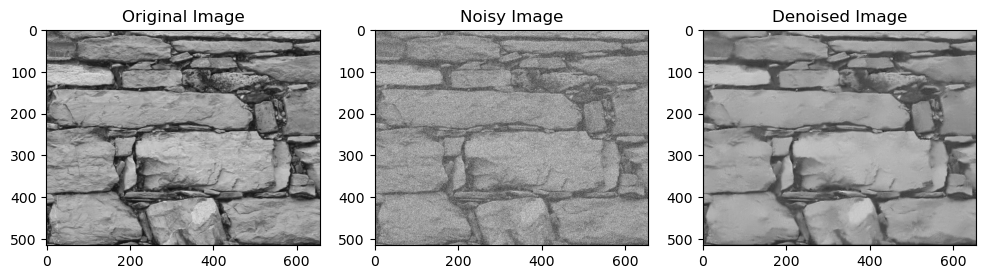

In [166]:
# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(im, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Noisy Image")
plt.imshow(imbr, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Denoised Image")
plt.imshow(denoised, cmap='gray')
plt.show()

In [189]:
def plot_denoising_results(original_image, noisy_image, denoised_image, sigma, psnr_value, execution_time):
    """
    Plots a 2x2 grid showing the original image, noisy image, denoised image, and the difference image.
    
    Parameters:
        original_image (numpy.ndarray): The original image.
        noisy_image (numpy.ndarray): The noisy version of the image.
        denoised_image (numpy.ndarray): The denoised image.
        difference_image (numpy.ndarray): The difference between the original and denoised images.
        psnr_value (float): The PSNR value for the denoised image.
        execution_time (str): A string representation of the execution time.
    """
    # Create 2x2 subplot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Plot original image
    axs[0, 0].imshow(original_image, cmap='gray')
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')

    # Plot noisy image
    axs[0, 1].imshow(noisy_image, cmap='gray')
    axs[0, 1].set_title(f"Noisy Image (std dev = {sigma})")
    axs[0, 1].axis('off')

    # Plot denoised image with PSNR subtitle
    axs[1, 0].imshow(denoised_image, cmap='gray')
    axs[1, 0].set_title(f"Denoised Image (PSNR: {psnr_value:.2f})")
    axs[1, 0].axis('off')

    # Plot difference image
    axs[1, 1].imshow(original_image - denoised_image, cmap='gray')
    axs[1, 1].set_title("Difference (Original - Denoised)")
    axs[1, 1].axis('off')

    # Add execution time as a note
    note = f'Execution time: {execution_time:.2f}s'
    fig.text(0.95, 0.05, note, ha='right', fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.show()


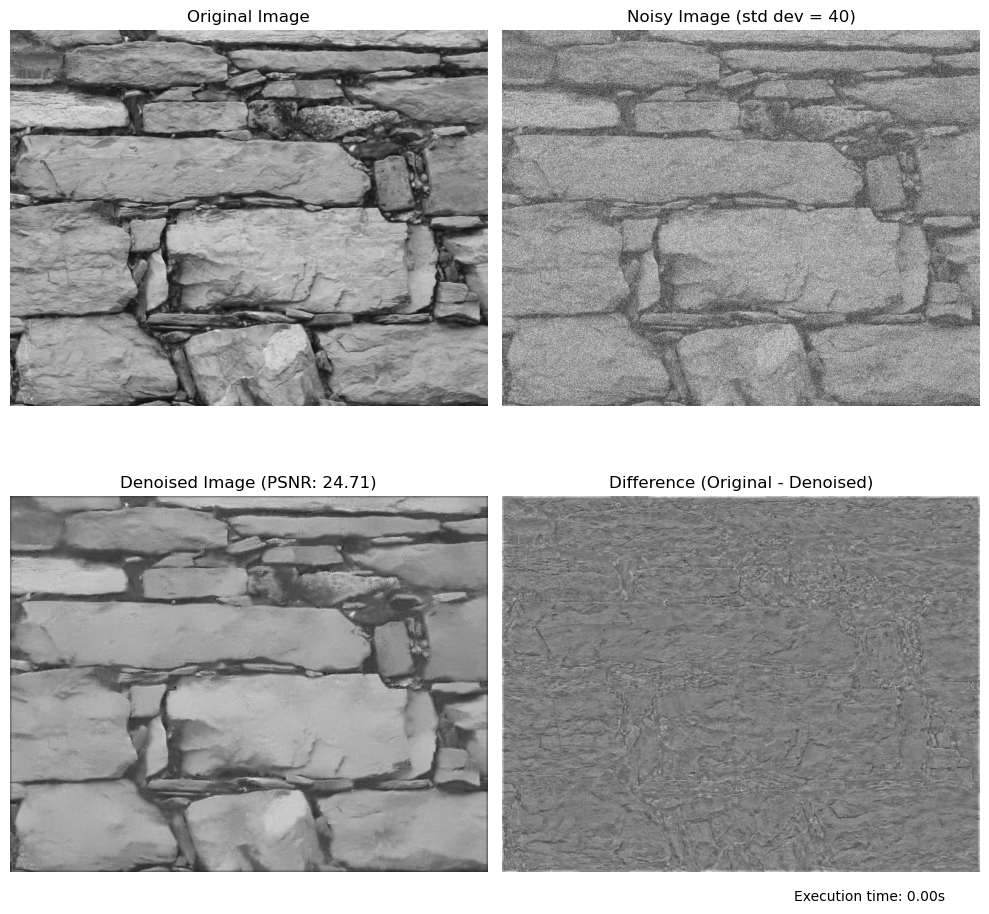

In [190]:
plot_denoising_results(im, imbr, denoised, sigma, psnr, exec_time)
